# Moon deconvolution

- Description.


 


479001600.0


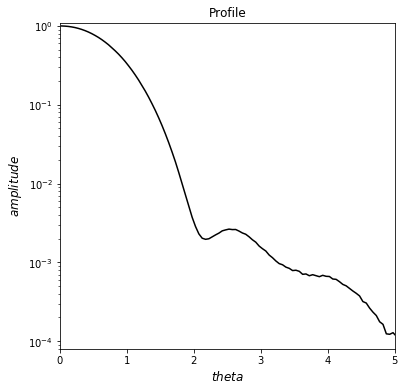

Angulo radial
(98,)
[ 0.025  0.075  0.125  0.175  0.225  0.275  0.325  0.375  0.425  0.475
  0.525  0.575  0.625  0.675  0.725  0.775  0.825  0.875  0.925  0.975
  1.025  1.075  1.125  1.175  1.225  1.275  1.325  1.375  1.425  1.475
  1.525  1.575  1.625  1.675  1.725  1.775  1.825  1.875  1.925  1.975
  2.025  2.075  2.125  2.175  2.225  2.275  2.325  2.375  2.425  2.475
  2.525  2.575  2.625  2.675  2.725  2.775  2.825  2.875  2.925  2.975
  3.025  3.075  3.125  3.175  3.225  3.275  3.325  3.375  3.425  3.475
  3.525  3.575  3.625  3.675  3.725  3.775  3.825  3.875  3.925  3.975
  4.025  4.075  4.125  4.175  4.225  4.275  4.325  4.375  4.425  4.475
  4.525  4.575  4.625  4.675  4.725  4.775  4.825  4.875]
Brightnees
(98,)
[  9.98306331e-01   9.93409418e-01   9.84856569e-01   9.70833443e-01
   9.52945523e-01   9.29738663e-01   9.02581983e-01   8.71291779e-01
   8.36634957e-01   7.98152112e-01   7.57045709e-01   7.14532994e-01
   6.69825845e-01   6.23379492e-01   5.77252023e-01   5.292

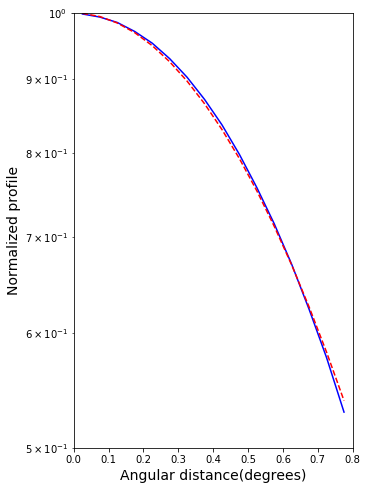

()
r_moon = 0.25
sigma  = 0.68560261683


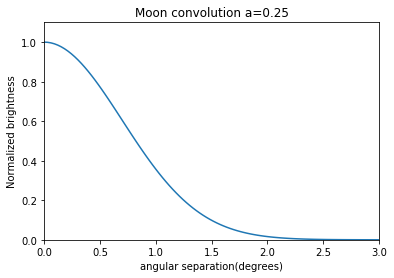

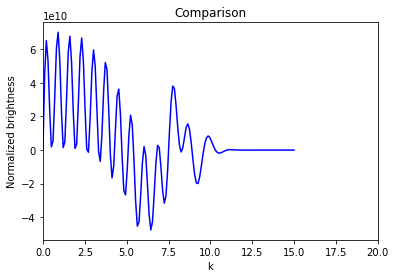

(13, 85)
(13,)
(85,)
(85,)


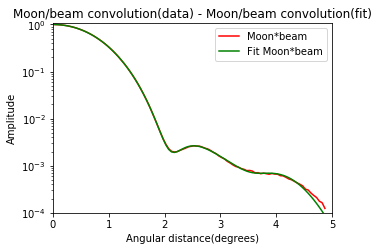

beam deconvolution comparison


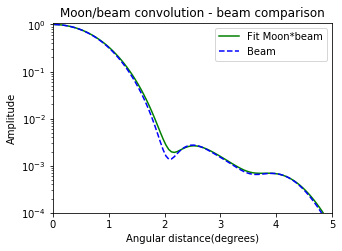

Moon reconvolution


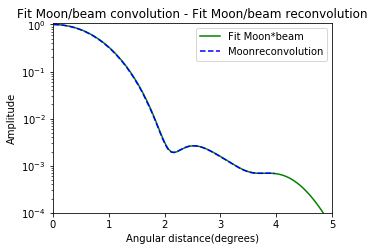

In [52]:
import numpy as np
from scipy.special import j0
from scipy.special import j1
import matplotlib.pyplot as plt
from scipy.special import hermite
from mpmath import *
from scipy.special import *
from scipy.integrate import quad
from scipy.optimize import curve_fit
from matplotlib.legend_handler import HandlerLine2D
import pickle


#######################################
def integrand(k,r,a,sigma):
    return  a*j0(k*r)*j1(k*a)*(2*np.pi*sigma**2)*np.exp(-(0.5)*(sigma**2)*(k**2))
#######################################                                   
def int_bessel(r,a,sigma):
    return quad(integrand, 0, np.inf, args=(r,a,sigma))[0]  
######################################
def integral_bessel(r_array, a, sigma):
    T_0 = int_bessel(0,a,sigma)    
    T   = np.zeros(r_array.shape[0])
    for i, r in enumerate(r_array):
        T[i] = int_bessel(r, a, sigma)/T_0    
    return T
#######################################
def integrand_hankel(r,k,i,sigma):
    return  j0(k*r)*r*(hermite(2*i)(r/sigma))*np.exp(-(0.5)*((r**2)/(sigma**2)))

def hankel_transform(k,i,sigma):
# Parameters are k, i, sigma.
    return quad(integrand_hankel, 0, np.inf, args=(k,i,sigma))[0] 

def inv_hankel_transform(r,i,sigma):
    return quad(integrand_hankel, 0, np.inf, args=(k,i,sigma))[0] 

def integral_hankel(k_array, i, sigma):
    H   = np.zeros(k_array.shape[0])
    for j, ka in enumerate(k_array):
        H[j] = hankel_transform(ka,i,sigma)    
    return H

def hankel_transform_basis(k,N_max,sigma):
    H = np.zeros([N_max + 1, k.shape[0]], dtype=float)
    for i in range(0, N_max + 1):
        H[i,:] = integral_hankel(k,i,sigma)    
    return H
#####################################################
def h2_trans(k,sigma):
    return 4*2*(sigma**2)*gamma(2)*hyp1f1(2, 1, -(sigma**2)*(k**2)/2) -2*(sigma**2)*gamma(1)*hyp1f1(1, 1, -(sigma**2)*(k**2)/2)
#####################################################
def pol_trans(k,n,sigma): 
    return (2**n)*(sigma**2)*gamma(n+1)*hyp1f1(n+1, 1, -(sigma**2)*(k**2)/2)
#####################################################
def basis_recons(k,n,sigma):  
    # Reconstruct a hermite polynomial of degree 2n (n index)
    coef = hermite(2*n).c   
    s    = coef.shape[0]
    H_k  = 0.0    
    for i in range(0, coef.shape[0]):
        if i % 2 == 0:
            H_k  = H_k + coef[s-1-i]*pol_trans(k,i/2,sigma)
        else:
            H_k  = H_k + 0.0        
    return  2*np.pi*H_k
###############################################################
def integrand_T_r_j(k,r,i,a,sigma):
     return a*j0(k*r)*j1(k*a)*basis_recons(k,i,sigma) 
################################################################    
def integrand_T_0_j(k,i,a,sigma):
     return a*j1(k*a)*basis_recons(k,i,sigma)       
################################################################   
def int_T_r_j(r_array,i,a,sigma):  
    I = np.zeros(r_array.shape[0])
    for j, radii in enumerate(r_array):
        I[j] = quad(integrand_T_r_j, 0, np.inf, args=(radii,i,a,sigma))[0]    
    return I
################################################################
def int_T_0_j(i,a,sigma):                    
    return quad(integrand_T_0_j, 0, np.inf, args=(i,a,sigma))[0]
################################################################
################################################################
################################################################
def fit_main_lobe(bol, theta_r, B_profile, a, sigma, n):        
    if bol == True:    
        bounds = ([a-0.00000001,sigma-0.2], [a, sigma + 0.2])        
        popt_beam_sigma, pcov_beam = curve_fit(integral_bessel, theta_r[:n], B_profile[:n], bounds = bounds)
        
        f = plt.figure()
        
        plt.plot(theta_r[:n], B_profile[:n],'b-', label = 'moon' )
        plt.plot(theta_r[:n], integral_bessel(theta_r[:n],*popt_beam_sigma),'--r',label ='fit' )
        
        plt.xlabel('Angular distance(degrees)', size =14.0)
        plt.ylabel('Normalized profile', size =14.0)
        plt.yscale('Log')
        plt.ylim([ 5*10**-1, 10**0])
        plt.xlim([0, 0.8])

        f = plt.gcf()
        f.set_size_inches(5.0,8.0)
        plt.show()       
        np.savetxt('popt_beam_sigma.txt', popt_beam_sigma, fmt='%s')
    else:
        popt_beam_sigma = np.loadtxt('popt_beam_sigma.txt', dtype = float)
                        
    return   popt_beam_sigma
################################################################
################################################################
################################################################
def Tmodes(bol,theta_r, N_cut,a,sigma): 
    if bol == True:       
        T_r_j = np.zeros([N_cut + 1, theta_r.shape[0]], dtype = float)
        T_0_j = np.zeros(N_cut + 1, dtype = float)
        for i in range(0, N_cut + 1):
            T_r_j[i,:] = int_T_r_j(theta_r,i,a,sigma)                     
            T_0_j[i]   = int_T_0_j(i, a, sigma)             
        np.savetxt('T_r_j_det57.txt', T_r_j, fmt='%s')
        np.savetxt('T_0_j_det57.txt', T_0_j, fmt='%s')         
    else: 
        T_r_j = np.loadtxt('T_r_j_det57.txt', dtype = float)
        T_0_j = np.loadtxt('T_0_j_det57.txt', dtype = float)     
    return T_r_j , T_0_j
################################################################
################################################################
################################################################
def normalized_map(r_array, c0, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11,c12, c13, c14, c15):
    coef = np.array([c0, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11,c12, c13, c14, c15])
    T_r = np.zeros([1, r_array.shape[0]], dtype = float)
    T_0 = 0.0
    for i in range(0, N_cut + 1):
               T_r = T_r + coef[i]*T_r_j[i,:]
               T_0 = T_0 + coef[i]*T_0_j[i]                
    T_r = T_r/T_0
    T_r = T_r.reshape([r_array.shape[0]]) 
    T_r = (10.0**16.0)*T_r
    return T_r
################################################################
################################################################
################################################################
def beam(theta_array, sigma, c0, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15):
    coef = np.array([c0, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10,c11,c12, c13, c14, c15])
    beam = 0.0
    for i in range(0, coef.shape[0]):
        beam  = beam + coef[i]*np.exp(-(theta_array**2)/(2*sigma**2))*(hermite(2*i)(theta_array/sigma))
    return beam
################################################################
################################################################
# Data loading 

print gamma(13)

beam_map    = pickle.load(open("beam57.p","rb"))
profile     = beam_map['Profile']
Profile_err = beam_map['Profile_err']
radius      = beam_map['r']

N_r_max   = 98   #[0,499] #the first piece for the gaussian fit.
B_profile = profile[:N_r_max]
theta_r   = radius[:N_r_max]

################################################################
################################################################

#Profile
plt.close('all')        
f, (ax2) = plt.subplots(1, sharex=True)
ax2.set_title('Profile')
ax2.plot(radius, profile ,'k', label='0')
ax2.set_xlabel('$theta$', size= 12)
ax2.set_ylabel('$amplitude$', size= 12) 
ax2.set_yscale('Log')
ax2.set_ylim([8*10**-5, 1.1])
ax2.set_xlim([0, 5])

#ax2.set_xlim([-4, 5])
#ax2.set_ylim([-3,4])
#ax2.set_xticks(ticks = [-4,-3,-2,-1,0,1,2,3,4,5] ,minor=False)

#plt.legend(loc=1)

f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)  

f = plt.gcf()
f.set_size_inches(6.0,6)   

#plt.savefig("/home/bastian/plots/hermite.pdf", bbox_inches="tight")
#plt.savefig("/home/bastian/plots/hermite.png", bbox_inches="tight")
plt.show()

################################################################
################################################################
print 'Angulo radial'
print  theta_r.shape
print  theta_r

print 'Brightnees'
print  B_profile.shape
print  B_profile
################################################################
#### Plot the data for the real beam profile #######
################################################################
#figure = plt.figure()
#plt.plot(theta_r[:N_r_max], B_profile[:N_r_max])
#plt.plot(theta_r, np.exp(-0.5*(sigma**-2.0)*(theta_r**2.0)))
#plt.yscale('Log')
#plt.ylim([10**-5,1])
#plt.show()
#plt.clf()
####################################################################
#                       Main lobe fitting
####################################################################
a       = 0.25
sigma   = 0.6301355           #Guess
radii    = np.linspace(0,3,100, dtype = float) 

# Sigma fit and plot 

a, sigma = fit_main_lobe(True, theta_r, B_profile, 0.25, 0.63, 16)
e_factor = 10.0**16.0

#np.savetxt('sigma_det57.txt', sigma, fmt='%s')
#sigma = np.loadtxt('sigma_det57.txt',dtype = float)

print sigma.shape
print 'r_moon = %s' %str(a)
print 'sigma  = %s' %str(sigma)

########################## Plotting ################################
#### The convolution between a unitary disc and a gaussian beam ####
####################################################################

# Gaussian_sigma_fit or second moment fit
plt.clf()
plt.figure() 
plt.plot(radii, integral_bessel(radii, a, sigma)) 
plt.xlim([0,3])
plt.ylim([0,1.1])
plt.xlabel('angular separation(degrees)')
plt.ylabel('Normalized brightness')
plt.title('Moon convolution %s' %'a=' + str(a) )

plt.show()
################################################
# Numerical vs analitical procedure. 
################################################
#hermite polynomial
k = np.linspace(0,15,150)
plt.clf()
plt.figure() 
#plt.plot(k, (10**-13)*basis_recons(k,10,sigma),'b')
#plt.plot(k, (10**-13)*2*np.pi*integral_hankel(k, 10, sigma),'r') 
plt.plot(k, integrand_T_r_j(k,4.5,10,0.25,sigma),'b')
plt.xlim([0,20])
#plt.yscale('Log')
#plt.ylim([10,1])
plt.xlabel('k')
plt.ylabel('Normalized brightness')
plt.title('Comparison')
plt.show()  
################################################
############ 4 Extras definitions ##############
################################################
N_cut = 12 # polinomial of degree 2*N_cut
T_r_j , T_0_j = Tmodes(False, theta_r, N_cut, a, sigma)
T_r_j = T_r_j[:,13:]

print T_r_j.shape
print T_0_j.shape 
theta_r   = theta_r.reshape([theta_r.shape[0],])
B_profile = B_profile.reshape([theta_r.shape[0],])

theta_r   = theta_r[13:]
B_profile = B_profile[13:]
print theta_r.shape
print B_profile.shape
###################################################
###################################################
# Guess
################
#Good  fit   

#guess32 =(e_factor)*np.array([  1.00000000e+00,  -8.36953162e-03,  -1.11449263e-03,
#         3.66654583e-05,   4.51707533e-07,   2.39336666e-08,
#        -1.04446620e-10,   2.04750072e-11,   5.32090851e-14,
#         1.67174354e-14,  -2.07808718e-17,   6.86061000e-18,
#        -4.65944464e-20,   1.63989116e-21,  -1.51807465e-23,
#         2.33499235e-25])

guess32 =(e_factor)*np.array([  1.00000000e+00,  -1.22401430e-02,  -1.17094885e-03, 4.33056294e-05,
                                4.47839220e-07,   1.69617105e-08,   1.30103568e-10, 1.00543073e-11,   
                                3.53248226e-13,   9.72593262e-15,   1.08402179e-16, 4.50714728e-18,
                               -9.91686510e-22,   0.00000000e+00,   0.00000000e+00, 0.00000000e+00])

B_profile = (e_factor)*B_profile
####################################################
# Bounds
lbound = (e_factor)*np.array([ 0.900,-1.0,-1.0,-1.0,
                              -1.0,-1.0,-1.0,-1.0,
                              -1.0,-1.0,-1.0,-1.0,
                              -1.0,-1.0,-1.0,-1.0])
ubound = (e_factor)*np.array([1.100, 1.0, 1.0, 1.0,
                              1.0, 1.0, 1.0, 1.0,
                              1.0, 1.0, 1.0, 1.0,
                              1.0, 1.0, 1.0, 1.0])
bounds = (lbound, ubound)
          
#################################################### 
#################################################### 
popt, pcov = curve_fit(normalized_map, theta_r, B_profile, bounds = bounds)  #

popt = (e_factor**-1)*popt
pcov =(e_factor**-2)*pcov
B_profile = (e_factor**-1)*B_profile

np.savetxt('parameters_det57_08.txt', popt, fmt='%s')
np.savetxt('covariance_det57_08.txt', pcov, fmt='%s')


#######################################################################
#########################     Plots     ###############################
#######################################################################

#t = (e_factor**-1)*normalized_map(theta_r, *popt)
B_profile = profile[:N_r_max]
theta_r   = radius[:N_r_max]

T_r_j , T_0_j = Tmodes(False, theta_r, N_cut, a, sigma)

t = (e_factor**-1)*normalized_map(theta_r, *popt)

#######################################################################
#result printing
fit_par_cov = False
if fit_par_cov == True:
    print t.shape
    print 'Fitting parameters'
    print popt
    print 'Covariance matrix'
    print pcov

#######################################################################

plt.clf()
plt.figure()
l1, = plt.plot(theta_r, B_profile,'r', label='Moon*beam')
l3, = plt.plot(theta_r, t,'g-', label='Fit Moon*beam')

plt.xlabel('Angular distance(degrees)')
plt.ylabel('Amplitude')
plt.yscale('Log')
plt.xlim([0,5])
plt.ylim([10**-4, 1.1])
plt.title('Moon/beam convolution(data) - Moon/beam convolution(fit)' )

plt.legend()
f = plt.gcf()
f.set_size_inches(5.0,3.5) 
#plt.savefig("/home/bastian/plots/Moon_beam_convolution_beam_data-fit.pdf", bbox_inches="tight")
#plt.savefig("/home/bastian/plots/Moon_beam_convolution_beam_data-fit.png", bbox_inches="tight")
plt.show()

########################################################################

print 'beam deconvolution comparison'

plt.clf()
plt.figure()

l3, = plt.plot(theta_r, t,'g-', label='Fit Moon*beam')
l2, = plt.plot(theta_r, beam(theta_r,sigma,*popt)/beam(0.0,sigma,*popt),'--b', label='Beam')

plt.xlabel('Angular distance(degrees)')
plt.ylabel('Amplitude')
plt.yscale('Log')
plt.xlim([0,5])
plt.ylim([10**-4, 1.1])
plt.title('Moon/beam convolution - beam comparison')

plt.legend()
f = plt.gcf()
f.set_size_inches(5.0,3.5) 
#plt.savefig("/home/bastian/plots/Moon_beam_convolution_beam_comparison.pdf", bbox_inches="tight")
#plt.savefig("/home/bastian/plots/Moon_beam_convolution_beam_comparison.png", bbox_inches="tight")
plt.show()
#######################################################################

# I dont know if it can change

########################################################################
#######################################################################
ave_rings = np.loadtxt('moon_convolution_profile.txt', dtype=float)
rad       = np.loadtxt('moon_convolution_radius.txt' , dtype=float)

#######################################################################
#result printing
#Radius
radius_ave_ring = False

if radius_ave_ring == True:
    
    print 'radius'
    print rad.shape
    print rad

    print 'ave_rings'
    print ave_rings.shape
    print ave_rings

########################################################################
########################################################################
########################################################################
print 'Moon reconvolution'

plt.clf()
plt.figure()

l3, = plt.plot(theta_r, t,'g', label = 'Fit Moon*beam')
l4, = plt.plot(rad[:297],ave_rings[:297]/ave_rings[1],'--b',label='Moonreconvolution')

plt.xlabel('Angular distance(degrees)')
plt.ylabel('Amplitude')
plt.yscale('Log')
plt.xlim([0,5])
plt.ylim([10**-4, 1.1])
plt.title('Fit Moon/beam convolution - Fit Moon/beam reconvolution')

plt.legend()
f = plt.gcf()
f.set_size_inches(5.0,3.5) 
#plt.savefig("/home/bastian/plots/Moon_beam_convolution_moon_beam_reconvolution.pdf", bbox_inches="tight")
#plt.savefig("/home/bastian/plots/Moon_beam_convolution_moon_beam_reconvolution.png", bbox_inches="tight")
plt.show()

#######################################################################
#result printing
basis = False

if basis == True: 
    for i in range(0,13):    
        plt.figure()
        plt.plot(theta_r, T_r_j[i,:])
        h = (hermite(2*i)(theta_r/sigma))*np.exp(-(0.5)*((theta_r**2)/(sigma**2)))/(hermite(2*i)(theta_r[0]/sigma))*np.exp(-(0.5)*((theta_r[0]**2)/(sigma**2))) 
        plt.plot(theta_r, h)
        plt.show()
        
############################################################
############################################################
############################################################


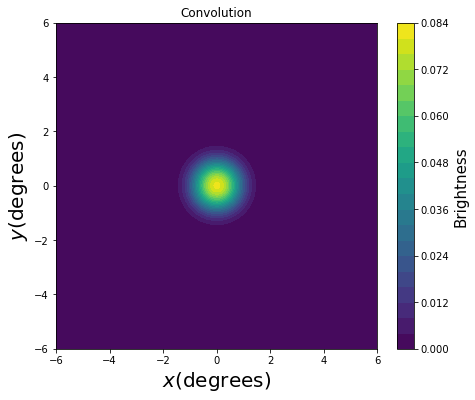

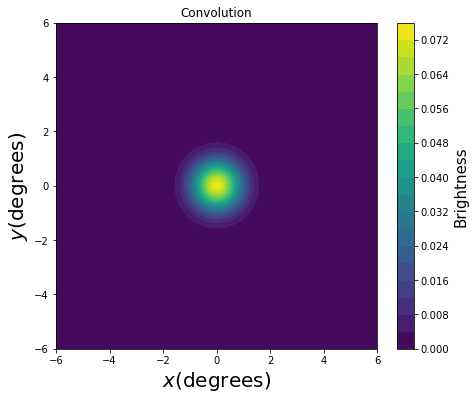

[[ 0.90445482  0.90447609]
 [ 0.90447609  0.90449743]]


/etc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:44: RuntimeWarning: invalid value encountered in divide


NameError: name 'rad' is not defined

In [36]:
# Consistency test
# Compute the convolution between the moon and the fit beam.
import numpy as np
from scipy import signal
from scipy import misc
import matplotlib.pyplot as plt
import pickle
from matplotlib.mlab import griddata
import numpy.ma as ma
from scipy.optimize import curve_fit
import scipy.optimize as opt
from scipy.special import hermite
################################################
def circle(x_array, y_array, radius):       
    moon = np.zeros([x_array.shape[0], y_array.shape[0]], dtype = float) 
    n_r  = moon.shape[0]
    #Density of points per angle.
    N    = moon.shape[0]/(2.0*np.amax(x_array))   
    r    = np.linspace(0, radius, N, dtype = float)   
    for k in range(0, r.shape[0]):       
        for i in range(-k + n_r/2, k + n_r/2 + 1):
            for j in range(-k + n_r/2, k + n_r/2 + 1):       
                if (x_array[i]**2 + y_array[j]**2 <= r[k]**2) : 
                    moon[i,j] = 1.0
    return moon

##################################################
def av_circle(x_array, y_array, Z):
    ''' This code can be inproved if you try to find 
           the coordinates of the center of your beam'''
    ''' this code doesn't use the y_array'''
    n_r = Z.shape[0]  #(assuming that dimension is a even number)   
    r   = np.linspace(0, 4, n_r/2 - 1, dtype = float)
    b_r = np.zeros(n_r/2 - 1, dtype = float)
    N_r = np.zeros(n_r/2 - 1, dtype = float)
    for k in range(0, r.shape[0] - 2): 
# Choose a k and do the following two index operation:        
        for i in range(-k + n_r/2, k + n_r/2 + 1):
            for j in range(-k + n_r/2, k + n_r/2 + 1):       
                if (x_array[i]**2 + y_array[j]**2 <= r[k+1]**2) and  (x_array[i]**2 + y_array[j]**2 > r[k]**2): 
                    N_r[k] = N_r[k] + 1.0
                    b_r[k] = b_r[k] + Z[i,j]
# Normalize for each k element:
    b_r = b_r/N_r
# Return the complete array:
    return r, b_r, N_r
##################################################
def beam(theta_array, sigma, c0, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12,c13,c14,c15):
    coef = np.array([c0, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12,c13,c14,c15])
    beam = 0.0
    for i in range(0, coef.shape[0]):
        beam  = beam + coef[i]*np.exp(-(theta_array**2)/(2*sigma**2))*(hermite(2*i)(theta_array/sigma))
    return beam

################################################
################################################

x = np.linspace(-6,6,600)
y = np.linspace(-6,6,600)
X, Y = np.meshgrid(x, y)

################################################
#               Load data
################################################

popt  = np.loadtxt('parameters_det57.txt', dtype = float)
sigma = 1.50/(2.0*(2.0*np.log(2))**0.5)    #np.loadtext('sigma_det57.text',dtype = float)
a     = 0.25
#Create array
Beam_kernel     = beam((X**2 + Y**2)**0.5, sigma,*popt)/beam(0.0,sigma,*popt)
Beam_kernel = Beam_kernel/np.sum(Beam_kernel)

# solid angle normalization
gaussian_kernel = np.exp(-0.5*((sigma)**-2)*(X**2 + Y**2))
gaussian_kernel = gaussian_kernel/np.sum(gaussian_kernel)

#Moon
#moon = circle(x,y,a)
#np.savetxt('moon.txt', moon, fmt='%s')
moon = np.loadtxt('moon.txt', dtype=float)
#
#moon_beam_convolution     = signal.convolve2d(moon, Beam_kernel, boundary='symm', mode='same')
#moon_gaussian_convolution = signal.convolve2d(moon, gaussian_kernel, boundary='symm', mode='same')

#np.savetxt('moon_beam_convolution.txt', moon_beam_convolution, fmt='%s')
moon_beam_convolution = np.loadtxt('moon_beam_convolution.txt', dtype=float)

#np.savetxt('moon_gaussian_convolution.txt',moon_gaussian_convolution, fmt='%s')
moon_gaussian_convolution = np.loadtxt('moon_gaussian_convolution.txt', dtype=float)


################################################################################
plt.clf()
plt.figure()
CM = plt.contourf(X, Y, moon_beam_convolution, 20)
plt.title('Convolution')
plt.xlabel('$x$(degrees)',fontsize=20)
plt.ylabel('$y$(degrees)',fontsize=20)
cbar = plt.colorbar(CM)
cbar.ax.set_ylabel('Brightness',fontsize=15)
f = plt.gcf()
f.set_size_inches(7.2,6.0)
plt.show()
#################################################################
plt.clf()
plt.figure()
CM = plt.contourf(X, Y, moon_gaussian_convolution, 20)
plt.title('Convolution')
plt.xlabel('$x$(degrees)',fontsize=20)
plt.ylabel('$y$(degrees)',fontsize=20)
cbar = plt.colorbar(CM)
cbar.ax.set_ylabel('Brightness',fontsize=15)
f = plt.gcf()
f.set_size_inches(7.2,6.0)
plt.show()
#################################################################

T = moon_gaussian_convolution/moon_beam_convolution


t = T[299:301,299:301]

print t

rad_beam , ave_rings_beam, Number_beam = av_circle(x,y,moon_beam_convolution)
rad_g , ave_rings_g, Number_g = av_circle(x,y,moon_gaussian_convolution)

#total_pixel = np.sum(Number)
print rad
print ave_rings

print rad.shape
print ave_rings.shape
################################################################
np.savetxt('moon_beam_convolution_profile_det57.txt', ave_rings_beam, fmt='%s') 
np.savetxt('moon_beam_convolution_radius.txt', rad_beam, fmt='%s')  
ave_rings_beam = np.loadtxt('moon_beam_convolution_profile_det57.txt', dtype=float)
rad_beam       = np.loadtxt('moon_beam_convolution_radius.txt', dtype=float)

np.savetxt('moon_gaussian_convolution_profile_det57.txt', ave_rings_g, fmt='%s') 
np.savetxt('moon_gaussian_convolution_radius.txt', rad_g, fmt='%s')  
ave_rings_g = np.loadtxt('moon__gaussian_convolution_profile_det57.txt', dtype=float)
rad_g      = np.loadtxt('moon_gaussian_convolution_radius.txt', dtype=float)
#################################################################
plt.clf()
plt.figure()
plt.plot(rad[:297],ave_rings[:297]/ave_rings[1])
plt.title('Averaged_moon_convolution',fontsize=15)
plt.xlabel('$r$(degrees)',fontsize=15)
plt.ylabel('brightness',fontsize=15)
plt.xlim([0,6])
plt.yscale('Log')

f = plt.gcf()
f.set_size_inches(4.0,5.7)

plt.show()
#################################################################

(251, 13)
(16,)
(16, 16)
[[  4.23975049e-21   7.43483572e-20   4.51673037e-18   4.08699081e-17
   -2.37977719e-18   1.28687090e-19  -5.66409499e-21   2.03158173e-22
   -6.12217946e-24   1.57325814e-25  -3.48735647e-27   6.40259393e-29
   -8.15069379e-31   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  7.43483572e-20   1.30378501e-18   7.92059357e-17   7.16709288e-16
   -4.16146992e-17   2.25275229e-18  -9.91734289e-20   3.55715383e-21
   -1.07192936e-22   2.75453975e-24  -6.10566738e-26   1.12093395e-27
   -1.42694626e-29   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  4.51673037e-18   7.92059357e-17   4.81182454e-15   4.35404956e-14
   -2.53023591e-15   1.36927052e-16  -6.02761436e-18   2.16198015e-19
   -6.51504862e-21   1.67418642e-22  -3.71100507e-24   6.81305991e-26
   -8.67307443e-28   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  4.08699081e-17   7.16709288e-16   4.35404956e-14   3.93991192e-13
   -2.27890130e-14   1.23545538e-15  -5.44034167e-17   1.95136

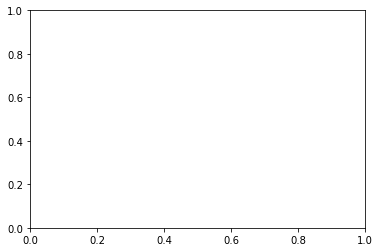

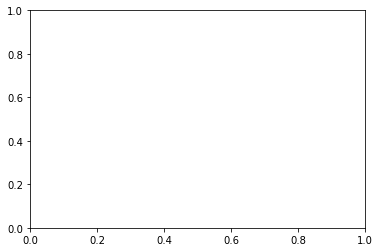

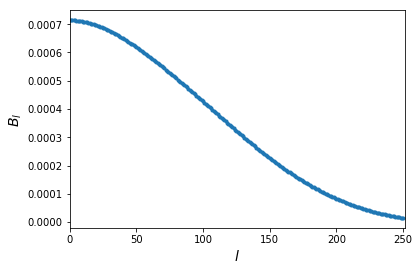

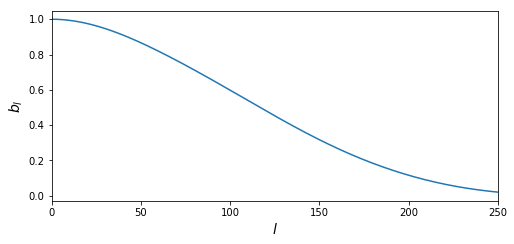

Covariance matrix of the fitting coefficients
(13, 13)
[[  4.23975049e-21   7.43483572e-20   4.51673037e-18   4.08699081e-17
   -2.37977719e-18   1.28687090e-19  -5.66409499e-21   2.03158173e-22
   -6.12217946e-24   1.57325814e-25  -3.48735647e-27   6.40259393e-29
   -8.15069379e-31]
 [  7.43483572e-20   1.30378501e-18   7.92059357e-17   7.16709288e-16
   -4.16146992e-17   2.25275229e-18  -9.91734289e-20   3.55715383e-21
   -1.07192936e-22   2.75453975e-24  -6.10566738e-26   1.12093395e-27
   -1.42694626e-29]
 [  4.51673037e-18   7.92059357e-17   4.81182454e-15   4.35404956e-14
   -2.53023591e-15   1.36927052e-16  -6.02761436e-18   2.16198015e-19
   -6.51504862e-21   1.67418642e-22  -3.71100507e-24   6.81305991e-26
   -8.67307443e-28]
 [  4.08699081e-17   7.16709288e-16   4.35404956e-14   3.93991192e-13
   -2.27890130e-14   1.23545538e-15  -5.44034167e-17   1.95136425e-18
   -5.88018114e-20   1.51097957e-21  -3.34908422e-23   6.14830896e-25
   -7.82651328e-27]
 [ -2.37977719e-18  -4.16

ValueError: cannot reshape array of size 251 into shape (250,)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import fft
from numpy.polynomial.hermite import hermval
from scipy.special import hermite
from scipy.special import legendre
import scipy.integrate as integrate

#Domain and parameters
theta = np.linspace(0,10,1000, dtype=float)
sigma = (2*np.pi/360.0)*0.6301355
# Defining two functions:
#1  The basis vector function that goes inside the integrand.
def basis(theta_array,sigma,l,i):
    B_l_i =(legendre(l)(np.cos(theta_array)))*np.exp(-(theta_array**2)/(2*sigma**2))*(hermite(2*i)(theta/sigma))
    return B_l_i

#2 Define the integral.
def basis_trans(sigma,l,i):
    #(standard deviation, l multipole moment in (harmonic space), i index for the hermite expansion)
    # Usual domain of the multipole moment(0,100) 
    # Usual domain of the hermite term(0,23) 
    B_l_i   = integrate.quad(lambda x: 2*np.pi*np.sin(x)*(legendre(l)(np.cos(x)))*np.exp(-(x**2)/(2*sigma**2))*(hermite(2*i)(x/sigma)), 0, 1)
    return B_l_i

##### Computing the first 80 multipole moment for each vector 12 its good
l_max = 250
i_max = 12
#################################################
#################################################
#################################################
#  Don't erase.
B = np.zeros([l_max + 1, i_max + 1], dtype = float)
for l in range(0,l_max + 1):
    for i in range(0,i_max + 1):
         B[l,i] = basis_trans(sigma,l,i)[0]
############# Save the array #################### 
name = 'B_ell_T_i_%s.txt' % str(l_max)

np.savetxt(name, B, fmt='%s')
B = np.loadtxt(name, dtype=float)[0:l_max + 1, 0:i_max + 1]
# Computig the multipoles component of the beam response function.
coef      = np.loadtxt('parameters.txt', dtype=float)
pcov_beam = np.loadtxt('covariance.txt', dtype=float)

print B.shape
print coef.shape
print pcov_beam.shape
print pcov_beam

# Dot product between B_l_i and c_i to get the component
b_ell = np.dot(B,coef[:i_max + 1]).reshape((B.shape[0],1))
b_ell = b_ell
b_ell_solid_angle = b_ell[0]

print 'solid angle'
print  b_ell[0]

######Creating the domain in harmonic space. #####
l  = np.arange(0, l_max + 1, 1) 
###################################################
####################Plotting#######################
###################################################
# Beam 
f = plt.figure()
plt.plot(l,b_ell,'.')
plt.xlim([0, l_max + 1])
plt.xlabel('$l$', size =14.0)

plt.ylabel('$B_{l}$', size =14.0)
g = plt.gcf()
g.set_size_inches(6,4)
plt.show()
###################################################
####################Plotting#######################
###################################################

# Normalized beam.
f = plt.figure()
plt.plot(l, b_ell/b_ell[0])
plt.xlim([0, l_max])
plt.xlabel('$l$', size =14.0)
plt.ylabel('$b_{l}$', size =14.0)
g = plt.gcf()
g.set_size_inches(6,4)

f = plt.gcf()
f.set_size_inches(8.0,3.5)
plt.savefig("/home/bastian/plots/normalized_beam_response_function_beam.png", bbox_inches="tight")

plt.show()
###################################################
###################################################
###################################################

# Manipulating the covariance matrix between different l's.
pcov_beam = pcov_beam[:i_max + 1,:i_max + 1]

print 'Covariance matrix of the fitting coefficients'
print pcov_beam.shape
print pcov_beam
print B.shape
print B

bt      = B.transpose()
Sigma_B = np.dot(B,np.dot(pcov_beam, bt))
print 'Sigma_B'
print Sigma_B.shape
print Sigma_B 
 
############print diag.shape###########
b_ell = b_ell.reshape([l_max,])
print 'b_ell'
print b_ell.shape 
print b_ell

###################################################
diag  =  np.diag(Sigma_B)
diag1 =  (diag**0.5)/b_ell
diag2 =  -(diag**0.5)/b_ell

print 'desviacion diag' 
print  diag1
###################################################
###beam uncertainty
f = plt.figure()
fig, (ax1) = plt.subplots(1, 1, sharex=True)

ax1.fill_between(l,diag2, diag1)
ax1.set_ylabel('between y1 and y2')
ax1.set_xlabel('$l$')
plt.plot(l,diag1,'k')
plt.plot(l,diag2,'k')
plt.xlabel('l', size= 12)
plt.ylabel('$\Delta B_{l}$', size= 12) #fractional deviation
plt.xlim([0, l_max ])

plt.show()
###################################################
# Print popt_beam.shape, pcov_beam.shape
# popt_beam
###################################################
# I don't really know if the main purpose is to compare 
#different beams independent od his beam response function.

############
Sigma_B = Sigma_B

#####  Normalized beam to unity ######
b_l = b_ell/b_ell[0]
b_l = b_l.reshape(b_l.shape[0], 1)
print b_l.shape

b_l_transpose = b_l.reshape(1, b_l.shape[0])
print b_l_transpose.shape

#####  Obtaining sigma values  #######
Sigma_B_row    = Sigma_B[:1,:l_max]
print Sigma_B_row.shape 

Sigma_B_column = Sigma_B[:l_max,:1]
print Sigma_B_column.shape

Sigma_00 = Sigma_B[0,0]

#####  Kroneker product example #######
b_l_l_prime = Sigma_00*np.kron(b_l_transpose, b_l)
Sigma_b_1 = np.kron(Sigma_B_row, b_l)  
Sigma_b_2 = np.kron(b_l_transpose, Sigma_B_column)

################## ######### ######### #########    
Sigma_b_l_l_prime = (Sigma_B + b_l_l_prime -Sigma_b_1 -Sigma_b_2)/((b_ell_solid_angle)**2)

Sigma_b_l_l_prime = np.diag(Sigma_b_l_l_prime)
Sigma_b_l_l_prime = np.sqrt(Sigma_b_l_l_prime)
Sigma_b_l_l_prime = Sigma_b_l_l_prime.reshape(Sigma_b_l_l_prime.shape[0],)
Sigma_b_l_l_prime = Sigma_b_l_l_prime

b_l = b_l.reshape(b_l.shape[0],)
l = l.reshape(l.shape[0],)

Sigma_b_l_l_prime = Sigma_b_l_l_prime


####saving the data#####
np.savetxt('/home/bastian/window_function/b_l.txt', b_l, fmt='%s') 
b_l = np.loadtxt('/home/bastian/window_function/b_l.txt', dtype=float)

np.savetxt('/home/bastian/window_function/l.txt', l, fmt='%s') 
l = np.loadtxt('/home/bastian/window_function/l.txt', dtype=float)

############################################################
#################### Plotting ##############################
############################################################
plt.clf()
f = plt.figure()
fig, (ax1) = plt.subplots(1, 1, sharex=True)

ax1.fill_between(l, Sigma_b_l_l_prime, -Sigma_b_l_l_prime)
ax1.set_ylabel('between y1 and y2')
ax1.set_xlabel('$l$')
plt.plot(l, Sigma_b_l_l_prime,'k')
plt.plot(l,-Sigma_b_l_l_prime,'k')
plt.xlabel('l', size= 12)
plt.ylabel('$\Delta b_{l}$', size= 12) #fractional deviation
plt.xlim([0, l_max ])

f = plt.gcf()
f.set_size_inches(8.0,4.5)
plt.savefig("/home/bastian/plots/residual_uncertainties_beam.png", bbox_inches="tight")

plt.show()
############################################################
########## Plotting the porcentual error  ##################
############################################################
np.savetxt('/home/bastian/window_function/Sigma_b_l_l_prime.txt', Sigma_b_l_l_prime, fmt='%s') 
Sigma_b_l_l_prime = np.loadtxt('/home/bastian/window_function/Sigma_b_l_l_prime.txt', dtype=float)

############################################################
plt.clf()
f = plt.figure()
fig, (ax1) = plt.subplots(1, 1, sharex=True)

ax1.fill_between(l, Sigma_b_l_l_prime/b_l, -Sigma_b_l_l_prime/b_l)
ax1.set_ylabel('between y1 and y2')
ax1.set_xlabel('$l$')
plt.plot(l, Sigma_b_l_l_prime/b_l,'k')
plt.plot(l,-Sigma_b_l_l_prime/b_l,'k')
plt.xlabel('l', size= 12)
plt.ylabel('$\Delta b_{l}/b_{l}$', size= 12)       #fractional deviation
plt.xlim([0, l_max - 50])
plt.ylim([-0.0075,0.0075])

f = plt.gcf()
f.set_size_inches(8.0,3.5)
plt.savefig("/home/bastian/plots/porcentual_residual_uncertainties_beam.png", bbox_inches="tight")

plt.show()

#############################################################
#############################################################
#############################################################
#  Computing the Window function and its uncertainty.
w_l = (b_ell/b_ell[0])**2

#Saving the data
np.savetxt('/home/bastian/window_function/w_l.txt', w_l, fmt='%s') 
w_l = np.loadtxt('/home/bastian/window_function/w_l.txt', dtype=float)

###################################################
####################Plotting#######################
###################################################
plt.clf()
f = plt.figure()
plt.plot(l,w_l)
plt.xlim([0, l_max])
plt.xlabel('$l$', size =14.0)
plt.ylabel('$w_{l}$', size =14.0)
g = plt.gcf()
g.set_size_inches(6,4)

f = plt.gcf()
f.set_size_inches(8.0,3.5)
plt.savefig("/home/bastian/plots/normalized_window_function_beam.png", bbox_inches="tight")

plt.show()
#########################################
#Uncertainties
########################################## 
########################################## 
########################################## 
Sigma_00 = Sigma_B[0,0]
####### 3 Kroneker product example #######
b_l           = b_l.reshape([b_l.shape[0],1])
b_l_transpose = b_l_transpose

print  b_l.shape
print  b_l_transpose.shape
Sigma_B = Sigma_B 
##########################################
b_l_l     = np.kron(b_l, b_l_transpose)

print b_l_l.shape
Sigma_w_1 = Sigma_B*b_l_l 
Sigma_w_2 = Sigma_00*np.kron(b_l_transpose**2, b_l**2)
Sigma_w_3 = np.kron(Sigma_B_row*b_l_transpose, b_l**2)
Sigma_w_4 = np.kron(b_l_transpose**2, Sigma_B_column*b_l)
##########################################    
Sigma_w_l_l_prime = 4.0*(Sigma_w_1 + Sigma_w_2 -Sigma_w_3 -Sigma_w_4)/((b_ell_solid_angle)**2)

Sigma_w_l_l_prime = np.diag(Sigma_w_l_l_prime)
Sigma_w_l_l_prime = np.sqrt(Sigma_w_l_l_prime)
Sigma_w_l_l_prime = Sigma_w_l_l_prime.reshape(Sigma_w_l_l_prime.shape[0],)
Sigma_w_l_l_prime = Sigma_w_l_l_prime

w_l               = w_l.reshape(w_l.shape[0],)
l                 = l.reshape(l.shape[0],)

Sigma_w_l_l_prime = Sigma_w_l_l_prime

############################################################
########## Plotting the porcentual error  ##################
############################################################

################### Saving the data ####################
np.savetxt('/home/bastian/window_function/Sigma_w_l_l_prime.txt', Sigma_w_l_l_prime, fmt='%s') 
Sigma_w_l_l_prime = np.loadtxt('/home/bastian/window_function/Sigma_w_l_l_prime.txt', dtype=float)



plt.clf()
f = plt.figure()
fig, (ax1) = plt.subplots(1, 1, sharex=True)

ax1.fill_between(l, Sigma_w_l_l_prime/w_l, -Sigma_w_l_l_prime/w_l)
ax1.set_ylabel('between y1 and y2')
ax1.set_xlabel('$l$')
plt.plot(l, Sigma_w_l_l_prime/w_l,'k')
plt.plot(l,-Sigma_w_l_l_prime/w_l,'k')
plt.xlabel('l', size= 12)
plt.ylabel('$\Delta w_{l}/w_{l}$', size= 12)       #fractional deviation
plt.xlim([0, l_max - 50])
plt.ylim([-0.015,0.015])

f = plt.gcf()
f.set_size_inches(8.0,3.5)
plt.savefig("/home/bastian/plots/porcentual_residual_uncertainties_window_function_beam.png", bbox_inches="tight")

plt.show()

#  Plot the results on window function


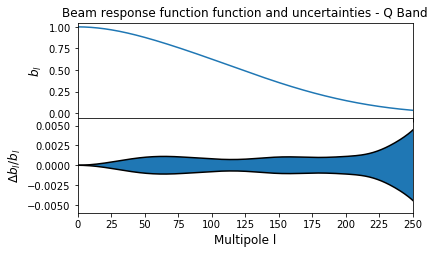

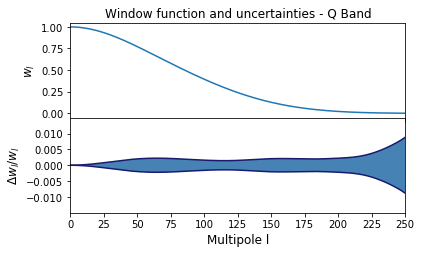

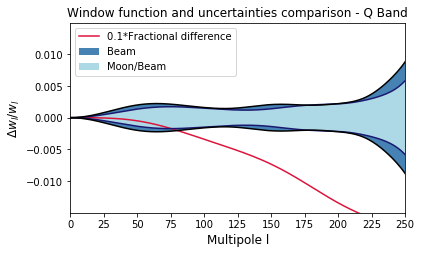

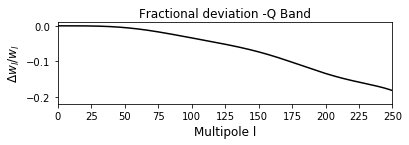

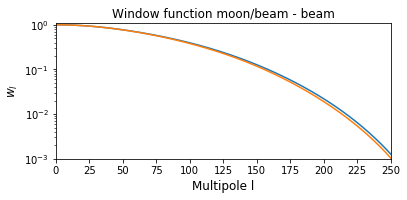

(300, 13)


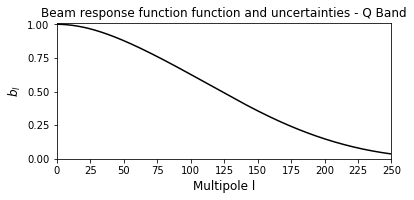

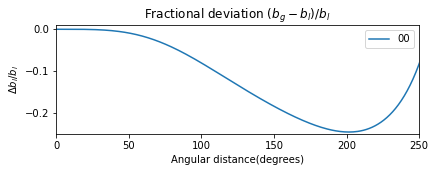

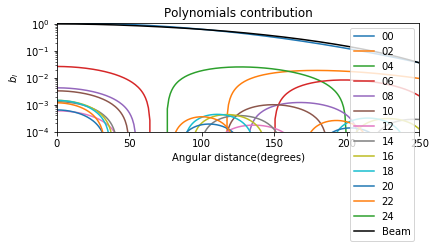

In [122]:
import numpy as np
import matplotlib.pyplot as plt


######################## Variables #############################
################################################################     
################################################################  

l   = np.loadtxt('/home/bastian/window_function/l.txt', dtype=float)
b_l = np.loadtxt('/home/bastian/window_function/b_l.txt', dtype=float)
Sigma_b_l_l_prime = np.loadtxt('/home/bastian/window_function/Sigma_b_l_l_prime.txt', dtype=float)

w_l = np.loadtxt('/home/bastian/window_function/w_l.txt', dtype=float)
Sigma_w_l_l_prime = np.loadtxt('/home/bastian/window_function/Sigma_w_l_l_prime.txt', dtype=float)


w_l_moon = np.loadtxt('/home/bastian/window_function/w_l_moon_det57.txt', dtype=float)
Sigma_w_l_l_prime_moon = np.loadtxt('/home/bastian/window_function/Sigma_w_l_l_prime_moon_det57.txt', dtype=float)

l_max = l.shape[0]
         
   
################################################################     
################################################################     
plt.close('all')        
f, (ax1, ax2) = plt.subplots(2, sharex=True)

ax1.plot(l, b_l, label = 'Beam response function' )
ax1.set_title('Beam response function function and uncertainties - Q Band')
ax1.set_ylabel('$b_{l}$', size= 12) 
ax1.set_yticks(ticks = [0, 0.25 ,0.5, 0.75,1] ,minor=False)

ax2.fill_between(l, Sigma_b_l_l_prime/b_l , -Sigma_b_l_l_prime/b_l, label ='Uncertainty' )
ax2.plot(l, Sigma_b_l_l_prime/b_l ,'k')
ax2.plot(l,-Sigma_b_l_l_prime/b_l ,'k')
ax2.set_xlabel('Multipole l', size= 12)
ax2.set_ylabel('$\Delta b_{l}/b_{l}$', size= 12)      
ax2.set_xlim([0, l_max - 50])
ax2.set_ylim([-0.006,0.006])
ax2.set_xticks(ticks = [0,25,50,75,100,125,150,175,200,225,250] ,minor=False)
ax2.set_yticks(ticks = [-0.005,-0.0025,0,0.0025 ,0.005] ,minor=False)

f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)  

f = plt.gcf()
f.set_size_inches(6.0,3.5)
plt.savefig("/home/bastian/plots/beam_response_function.pdf", bbox_inches="tight")       
plt.show()

###############################################################  
#                   Beam response function
################################################################     
plt.close('all')        
f, (ax1, ax2) = plt.subplots(2, sharex=True)

ax1.plot(l, w_l, label='Beam window function')
ax1.set_title('Window function and uncertainties - Q Band')
ax1.set_ylabel('$w_{l}$', size= 12) 
ax1.set_yticks(ticks = [0, 0.25 ,0.5, 0.75,1] ,minor=False)

ax2.fill_between(l, Sigma_w_l_l_prime/w_l, -Sigma_w_l_l_prime/w_l, facecolor='steelblue',label='Uncertainty')   #'lightcyan') #royalblue') #lightcyan
ax2.plot(l, Sigma_w_l_l_prime/w_l,'midnightblue') #'royalblue')   #'steelblue'
ax2.plot(l,-Sigma_w_l_l_prime/w_l,'midnightblue')
ax2.set_xlabel('Multipole l', size= 12)
ax2.set_ylabel('$\Delta w_{l}/w_{l}$', size= 12)      
ax2.set_xlim([0, l_max - 50])
ax2.set_ylim([-0.015,0.015])
ax2.set_yticks(ticks = [-0.01,-0.005 ,0, 0.005,0.01] ,minor=False)
ax2.set_xticks(ticks = [0,25,50,75,100,125,150,175,200,225,250] ,minor=False)


f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)  

f = plt.gcf()
f.set_size_inches(6.0,3.5)  
plt.savefig("/home/bastian/plots/window_function.pdf", bbox_inches="tight")
plt.savefig("/home/bastian/plots/window_function.png", bbox_inches="tight")
plt.show()
################################################################


################################################################  
#                   Window function
################################################################    
plt.close('all')        
f, (ax2) = plt.subplots(1, sharex=True)

ax2.set_title('Window function and uncertainties comparison - Q Band')
ax2.set_ylabel('$w_{l}$', size= 12) 

ax2.fill_between(l, Sigma_w_l_l_prime/w_l, -Sigma_w_l_l_prime/w_l, facecolor='steelblue', label='Beam') 
ax2.fill_between(l, Sigma_w_l_l_prime_moon/w_l_moon, -Sigma_w_l_l_prime_moon/w_l_moon, facecolor='lightblue', label='Moon/Beam') 

ax2.plot(l, (10**-1)*(w_l_moon-w_l)/w_l,'crimson', label='0.1*Fractional difference')

ax2.plot(l, Sigma_w_l_l_prime_moon/w_l_moon,'midnightblue')
ax2.plot(l,-Sigma_w_l_l_prime_moon/w_l_moon,'midnightblue')

ax2.plot(l, Sigma_w_l_l_prime/w_l,'k')
ax2.plot(l,-Sigma_w_l_l_prime/w_l,'k')
####
ax2.set_xlabel('Multipole l', size= 12)
ax2.set_ylabel('$\Delta w_{l}/w_{l}$', size= 12)      
ax2.set_xlim([0, l_max - 50])
ax2.set_ylim([-0.015,0.015])
ax2.set_yticks(ticks = [-0.01,-0.005 ,0, 0.005,0.01] ,minor=False)
ax2.set_xticks(ticks = [0,25,50,75,100,125,150,175,200,225,250] ,minor=False)
plt.legend(loc = 2)

f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)  

f = plt.gcf()
f.set_size_inches(6.0,3.5)  
plt.savefig("/home/bastian/plots/uncertainties_window_function.pdf", bbox_inches="tight")
plt.savefig("/home/bastian/plots/uncertainties_window_function.png", bbox_inches="tight")
plt.show()

################################################################  
#                   Fractional deviation
################################################################     
plt.close('all')        
f, (ax2) = plt.subplots(1, sharex=True)

ax2.set_title('Fractional deviation -Q Band')
ax2.set_ylabel('$w_{l}$', size= 12) 
ax2.plot(l, (w_l_moon - w_l)/w_l,'k')

ax2.set_xlabel('Multipole l', size= 12)
ax2.set_ylabel('$\Delta w_{l}/w_{l}$', size= 12)      
ax2.set_xlim([0, l_max - 50])
ax2.set_ylim([-0.22,0.01])
ax2.set_xticks(ticks = [0,25,50,75,100,125,150,175,200,225,250] ,minor=False)

f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)  

f = plt.gcf()
f.set_size_inches(6.0,1.5)   

plt.savefig("/home/bastian/plots/fractional_deviation.pdf", bbox_inches="tight")
plt.savefig("/home/bastian/plots/fractional_deviation.png", bbox_inches="tight")

plt.show()

################################################################    
plt.close('all')        
f, (ax2) = plt.subplots(1, sharex=True)

ax2.set_title('Window function moon/beam - beam')
ax2.set_ylabel('$w_{l}$', size= 12) 

ax2.plot(l, w_l) 
ax2.plot(l, w_l_moon) 

ax2.set_xlabel('Multipole l', size= 12)
ax2.set_ylabel('$w_{l}$', size= 12)      
ax2.set_xlim([0, l_max - 50])

ax2.set_yticks(ticks = [-0.01,-0.005 ,0, 0.005,0.01] ,minor = False)
ax2.set_xticks(ticks = [0,25,50,75,100,125,150,175,200,225,250] ,minor = False)
ax2.set_yscale('Log')
ax2.set_ylim([10**-3,1.1])
plt.legend(loc = 2)

f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)  

f = plt.gcf()
f.set_size_inches(6.0,2.5)  
plt.savefig("/home/bastian/plots/window_function_moon_beam.pdf", bbox_inches="tight")
plt.savefig("/home/bastian/plots/window_function_moon_beam.png", bbox_inches="tight")
plt.show()
################################################################

N_cut = 13 #number of polynomials
B     = np.loadtxt(name, dtype=float)[0:300, 0:N_cut]
c     = np.loadtxt('parameters.txt', dtype=float)

b_ell = np.dot(B,c[:N_cut]).reshape((B.shape[0],))

norm_b = b_ell[0]
b_ell = b_ell/b_ell[0]

print B.shape


################################################################     
################################################################     
plt.close('all')        
f, (ax2) = plt.subplots(1, sharex=True)
ax2.set_title('Beam response function function and uncertainties - Q Band')
ax2.plot(l, b_ell ,'k')
ax2.set_xlabel('Multipole l', size= 12)
ax2.set_ylabel('$b_{l}$', size= 12)      
ax2.set_xlim([0, l_max - 50])
ax2.set_ylim([0,1.01])
ax2.set_xticks(ticks = [0,25,50,75,100,125,150,175,200,225,250] ,minor=False)
ax2.set_yticks(ticks = [0,0.25,0.5,0.75,1] ,minor=False)

f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)  

f = plt.gcf()
f.set_size_inches(6.0,2.5)
#plt.savefig("/home/bastian/plots/beam_response_function.pdf", bbox_inches="tight")       
plt.show()

################################################################     
################################################################ 

b_g = c[0]*B[0:300,0]/norm_b
b_g = b_g/b_g[0]


plt.clf()
plt.figure()

l0,   = plt.plot(l,(b_g - b_ell)/b_ell, label='00')
#l2,   = plt.plot(l,c[1]*B[0:300,1]/norm_b, label='02')
#l4,   = plt.plot(l,c[2]*B[0:300,2]/norm_b, label='04')
#l6,   = plt.plot(l,c[3]*B[0:300,3]/norm_b, label='06')
#l8,   = plt.plot(l,c[4]*B[0:300,4]/norm_b, label='08')
#l10,  = plt.plot(l,c[5]*B[0:300,5]/norm_b, label='10')
#l12,  = plt.plot(l,c[6]*B[0:300,6]/norm_b, label='12')
#l14,  = plt.plot(l,c[7]*B[0:300,7]/norm_b, label='14')
#l00,  = plt.plot(l, b_ell,'k', label='Beam')

plt.xlabel('Angular distance(degrees)')
plt.ylabel('$\Delta b_{l}/b_{l}$')
#plt.yscale('Log')
plt.xlim([0,250])
plt.ylim([-0.25, 0.01])
plt.title('Fractional deviation $(b_{g} - b_{l})/b_{l}$')

plt.legend(loc = 1)
f = plt.gcf()
f.set_size_inches(6.5,2.0) 
plt.savefig("/home/bastian/plots/Contributions_beam_response_comparison.pdf", bbox_inches="tight")
plt.savefig("/home/bastian/plots/Contributions_beam_response_comparison.png", bbox_inches="tight")
plt.show()

########################################################################

plt.clf()
plt.figure()

l0,   =  plt.plot(l,c[0]*B[0:300,0]/norm_b, label='00')
l2,   = plt.plot(l,c[1]*B[0:300,1]/norm_b, label='02')
l4,   = plt.plot(l,c[2]*B[0:300,2]/norm_b, label='04')
l6,   = plt.plot(l,c[3]*B[0:300,3]/norm_b, label='06')
l8,   = plt.plot(l,c[4]*B[0:300,4]/norm_b, label='08')
l10,  = plt.plot(l,c[5]*B[0:300,5]/norm_b, label='10')
l12,  = plt.plot(l,c[6]*B[0:300,6]/norm_b, label='12')
l14,  = plt.plot(l,c[7]*B[0:300,7]/norm_b, label='14')
l16,  = plt.plot(l,c[8]*B[0:300,8]/norm_b, label='16')
l18,  = plt.plot(l,c[9]*B[0:300,9]/norm_b, label='18')
l20,  = plt.plot(l,c[10]*B[0:300,10]/norm_b, label='20')
l22,  = plt.plot(l,c[11]*B[0:300,11]/norm_b, label='22')
l24,  = plt.plot(l,c[12]*B[0:300,12]/norm_b, label='24')

l00,  = plt.plot(l, b_ell,'k', label='Beam')

plt.xlabel('Angular distance(degrees)')
plt.ylabel('$b_{l}$')
plt.yscale('Log')
plt.xlim([0,250])
plt.ylim([10**-4, 1.1])
plt.title('Polynomials contribution')

plt.legend(loc = 1)
f = plt.gcf()
f.set_size_inches(6.5,2.0) 
plt.savefig("/home/bastian/plots/Contributions_beam_response.pdf", bbox_inches="tight")
plt.savefig("/home/bastian/plots/Contributions_beam_response.png", bbox_inches="tight")
plt.show()



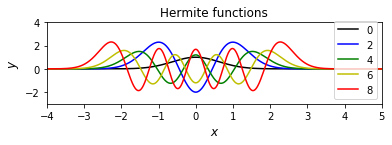

In [2]:
import numpy as np
from scipy.special import j0
from scipy.special import j1
import matplotlib.pyplot as plt
from scipy.special import hermite
from mpmath import *
from scipy.special import *
from scipy.integrate import quad
from scipy.optimize import curve_fit
from matplotlib.legend_handler import HandlerLine2D


x= np.linspace(-4,5,1000)          
     
####################################################

plt.close('all')        
f, (ax2) = plt.subplots(1, sharex=True)

ax2.set_title('Hermite functions')

ax2.plot(x, np.exp(-(x**2)/(2*sigma**2))*(hermite(2*0)(x/sigma)),'k', label='0')
ax2.plot(x, np.exp(-(x**2)/(2*sigma**2))*(hermite(2*1)(x/sigma)),'b',label='2')
ax2.plot(x, (10**-1)*np.exp(-(x**2)/(2*sigma**2))*(hermite(2*2)(x/sigma)),'g',label='4')
ax2.plot(x, (10**-2)*np.exp(-(x**2)/(2*sigma**2))*(hermite(2*3)(x/sigma)),'y',label='6')
ax2.plot(x, (10**-3)*np.exp(-(x**2)/(2*sigma**2))*(hermite(2*4)(x/sigma)),'r',label='8')


ax2.set_xlabel('$x$', size= 12)
ax2.set_ylabel('$y$', size= 12) 


ax2.set_xlim([-4, 5])
ax2.set_ylim([-3,4])
ax2.set_xticks(ticks = [-4,-3,-2,-1,0,1,2,3,4,5] ,minor=False)

plt.legend(loc=4)

f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)  

f = plt.gcf()
f.set_size_inches(6.0,1.5)   

plt.savefig("/home/bastian/plots/hermite.pdf", bbox_inches="tight")
plt.savefig("/home/bastian/plots/hermite.png", bbox_inches="tight")

plt.show()
##############






#  Contribution


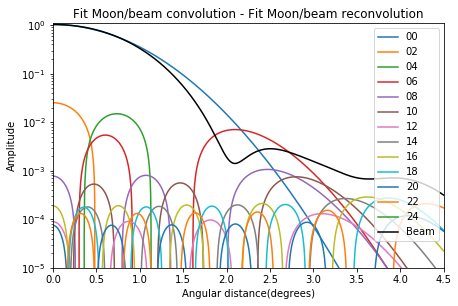

In [63]:
# Contribution of each hemrite polynomial
import numpy as np
from scipy.special import j0
from scipy.special import j1
import matplotlib.pyplot as plt
from scipy.special import hermite
from mpmath import *
from scipy.special import *
from scipy.integrate import quad
from scipy.optimize import curve_fit
from matplotlib.legend_handler import HandlerLine2D
import pickle

########################################################################
beam_map    = pickle.load(open("beam57.p","rb"))
profile     = beam_map['Profile']
Profile_err = beam_map['Profile_err']
radius      = beam_map['r']

########################################################################
theta_r   = np.linspace(0,4.5,1000)
sigma     = 0.68560261683
########################################################################
def beam(theta_array, sigma, c0, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15):
    coef = np.array([c0, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10,c11,c12, c13, c14, c15])
    beam = 0.0
    for i in range(0, coef.shape[0]):
        beam  = beam + coef[i]*np.exp(-(theta_array**2)/(2*sigma**2))*(hermite(2*i)(theta_array/sigma))
    return beam
########################################################################
c = np.loadtxt('parameters.txt', dtype=float)
########################################################################

plt.clf()
plt.figure()

l0,  = plt.plot(theta_r, c[0]*np.exp(-(theta_r**2)/(2*sigma**2))*(hermite(2*0)(theta_r/sigma)), label='00')
l1,  = plt.plot(theta_r, c[1]*np.exp(-(theta_r**2)/(2*sigma**2))*(hermite(2*1)(theta_r/sigma)), label='02')
l2,  = plt.plot(theta_r, c[2]*np.exp(-(theta_r**2)/(2*sigma**2))*(hermite(2*2)(theta_r/sigma)), label='04')
l3,  = plt.plot(theta_r, c[3]*np.exp(-(theta_r**2)/(2*sigma**2))*(hermite(2*3)(theta_r/sigma)), label='06')
l4,  = plt.plot(theta_r, c[4]*np.exp(-(theta_r**2)/(2*sigma**2))*(hermite(2*4)(theta_r/sigma)), label='08')
l5,  = plt.plot(theta_r, c[5]*np.exp(-(theta_r**2)/(2*sigma**2))*(hermite(2*5)(theta_r/sigma)), label='10')
l6,  = plt.plot(theta_r, c[6]*np.exp(-(theta_r**2)/(2*sigma**2))*(hermite(2*6)(theta_r/sigma)), label='12')
l7,  = plt.plot(theta_r, c[7]*np.exp(-(theta_r**2)/(2*sigma**2))*(hermite(2*7)(theta_r/sigma)), label='14')
l8,  = plt.plot(theta_r, c[8]*np.exp(-(theta_r**2)/(2*sigma**2))*(hermite(2*8)(theta_r/sigma)), label='16')
l9,  = plt.plot(theta_r, c[9]*np.exp(-(theta_r**2)/(2*sigma**2))*(hermite(2*9)(theta_r/sigma)), label='18')
l10, = plt.plot(theta_r, c[10]*np.exp(-(theta_r**2)/(2*sigma**2))*(hermite(2*10)(theta_r/sigma)), label='20')
l11, = plt.plot(theta_r, c[11]*np.exp(-(theta_r**2)/(2*sigma**2))*(hermite(2*11)(theta_r/sigma)), label='22')
l12, = plt.plot(theta_r, c[12]*np.exp(-(theta_r**2)/(2*sigma**2))*(hermite(2*12)(theta_r/sigma)), label='24')

l00, = plt.plot(theta_r, beam(theta_r,sigma,*c),'k', label='Beam')

plt.xlabel('Angular distance(degrees)')
plt.ylabel('Amplitude')
plt.yscale('Log')
plt.xlim([0,4.5])
plt.ylim([10**-5, 1.1])
plt.title('Fit Moon/beam convolution - Fit Moon/beam reconvolution')

plt.legend(loc = 1)
f = plt.gcf()
f.set_size_inches(7.0,4.5) 
plt.savefig("/home/bastian/plots/Contributions.pdf", bbox_inches="tight")
plt.savefig("/home/bastian/plots/Contributions.png", bbox_inches="tight")
plt.show()

########################################################################

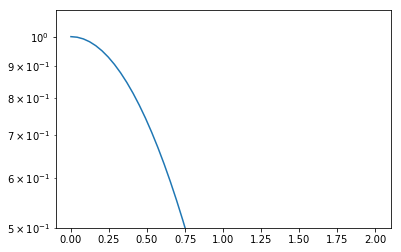

In [8]:
import numpy as np
import matplotlib.pyplot as plt



x = np.linspace(0,2,50)

plt.figure()
plt.plot(x,np.exp(-0.5*((sigma)**-2)*x**2))
plt.yscale('Log')
plt.ylim([5*10**-1,1.1])
plt.show()



In [39]:
import numpy as np

x = np.linspace(-6,6,600)
y = np.linspace(-6,6,600)

X,Y = np.meshgrid(x,y)


print X.shape
print X[299:301,299:301]


################################
################################
t = (0.5*(0.90447609 + 0.90449743))**-1
print 'T_beam/T_g'
print t
################################
################################



(600, 600)
[[-0.01001669  0.01001669]
 [-0.01001669  0.01001669]]
T_beam/T_g
1.10559937881


In [57]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import numpy.ma as ma
from scipy.optimize import curve_fit
from matplotlib.mlab import griddata
import glob

######################################################################
######################################################################
#folder = glob.glob("/data/users/zxu/share/moon/scans/temp/*")
                  
# Folders organized by month
matching_08 = [s for s in folder if "/data/users/zxu/share/moon/scans/temp/scan2017-08" in s]


##################################################################
profile = 0.0
n       = 0.0

for i in range(0,len(matching_08)):
    name     = matching_08[i]+'/data/Det57.p'
    
    matching_08_new = matching_08[i].split('/')
    print matching_08_new[len(matching_08_new)-1] 

    radial_brightness = '/home/bastian/radial_profiles/Det57/'+'radial_brightness_08' + matching_08_new[len(matching_08_new)-1] +'.txt'
   
    profile   = profile + np.loadtxt(radial_brightness, dtype=float)
    n         = n + 1
    
#################################################################
r_name       = '/home/bastian/radial_profiles/Det57/'+'radial_coordinate_08' + matching_08_new[len(matching_08_new)-1] +'.txt'
r            = np.loadtxt(r_name, dtype=float)
profile      = profile/n   

name_profile = '/home/bastian/radial_profiles/Det57/'+'ave_profile_08'+'.txt'
name_radial = '/home/bastian/radial_profiles/Det57/'+'radius_08'+'.txt'
    
np.savetxt(name_profile, profile, fmt='%s') 
np.savetxt(name_radial, r, fmt='%s') 

#################################################################
plt.clf()
figure = plt.figure()
ave_profile = plt.plot(r, profile)

plt.title('Profile57_august',fontsize=15)
plt.xlabel('$r$(degrees)',fontsize=15)
plt.ylabel('brightness',fontsize=15)
plt.xlim([0,10])
plt.yscale('Log')

f = plt.gcf()
f.set_size_inches(4.0,5.7)

plt.show()
#################################################################
plt.clf()
figure = plt.figure()
ave_profile = plt.plot(r, profile)

plt.title('Profile57_august',fontsize=15)
plt.xlabel('$r$(degrees)',fontsize=15)
plt.ylabel('Amplitude',fontsize=15)
plt.xlim([0,4.5])
plt.yscale('Log')
plt.ylim([10**-4, 1.3])

f = plt.gcf()
f.set_size_inches(5.0,6.8)

plt.show()
#################################################################

scan2017-08-07-23-49


IOError: [Errno 2] No such file or directory: '/home/bastian/radial_profiles/Det57/radial_brightness_08scan2017-08-07-23-49.txt'

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import numpy.ma as ma
from scipy.optimize import curve_fit
from matplotlib.mlab import griddata
import glob




######################################################################
######################################################################
folder = glob.glob("/data/users/zxu/share/moon/scans/temp/*")
                  
# Folders organized by month
matching_02 = [s for s in folder if "/data/users/zxu/share/moon/scans/temp/scan2017-02" in s]


##################################################################
profile = 0.0
n       = 0.0

for i in range(0, len(matching_02)):
    name            = matching_02[i]+'/data/Det57.p'
    matching_02_new = matching_02[i].split('/')
    print matching_02_new[len(matching_02_new)-1] 

    radial_brightness = '/home/bastian/radial_profiles/Det57/'+'radial_brightness_02' + matching_02_new[len(matching_02_new)-1] +'.txt'
   
    profile           = profile + np.loadtxt(radial_brightness, dtype=float)
    n                 = n + 1
    
#################################################################
r_name       = '/home/bastian/radial_profiles/Det57/'+'radial_coordinate_02' + matching_02_new[len(matching_02_new)-1] +'.txt'
r            = np.loadtxt(r_name, dtype=float)
  
radial_brightness_04 = '/home/bastian/radial_profiles/Det57/'+'radial_brightness_02' + matching_02_new[3] +'.txt'

profile      = (profile - np.loadtxt(radial_brightness_04, dtype=float))/(n-1)

name_profile = '/home/bastian/radial_profiles/Det57/'+'ave_profile_02'+'.txt'
name_radial = '/home/bastian/radial_profiles/Det57/'+'radius_02'+'.txt'
    
np.savetxt(name_profile, profile, fmt='%s') 
np.savetxt(name_radial, r, fmt='%s') 

#################################################################
plt.clf()
figure = plt.figure()
ave_profile = plt.plot(r, profile)

plt.title('Profile57_august',fontsize=15)
plt.xlabel('$r$(degrees)',fontsize=15)
plt.ylabel('brightness',fontsize=15)
plt.xlim([0,10])
plt.yscale('Log')

f = plt.gcf()
f.set_size_inches(4.0,5.7)

plt.show()
#################################################################
plt.clf()
figure = plt.figure()
ave_profile = plt.plot(r, profile)

plt.title('Profile57_august',fontsize=15)
plt.xlabel('$r$(degrees)',fontsize=15)
plt.ylabel('Amplitude',fontsize=15)
plt.xlim([0,4.5])
plt.yscale('Log')
plt.ylim([10**-4, 1.3])

f = plt.gcf()
f.set_size_inches(5.0,6.8)

plt.show()
#################################################################

scan2017-02-17-05-28
scan2017-02-17-11-38
scan2017-02-15-09-50
scan2017-02-26-12-37
scan2017-02-13-03-01
scan2017-02-18-07-15
scan2017-02-13-07-37
scan2017-02-18-11-17
scan2017-02-15-04-13
scan2017-02-18-13-26
scan2017-02-14-08-49
scan2017-02-14-03-37
scan2017-02-23-12-47
scan2017-02-18-05-10
scan2017-02-16-04-50
scan2017-02-16-10-45


IOError: [Errno 2] No such file or directory: '/home/bastian/radial_profiles/Det57/radial_brightness_02zxu.txt'

In [75]:
#matching_08 = [s for s in folder if "/data/users/zxu/share/moon/scans/temp/scan2017-08" in s]

matching_02 = [s for s in folder if "/home/bastian/radial_profiles/Det57/radial_coordinate_08scan2017" in s]
print matching_02



[]


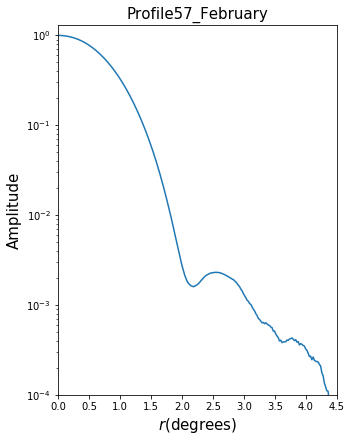

In [133]:
radial_brightness_01 = '/home/bastian/radial_profiles/Det57/radial_brightness_02scan2017-02-13-03-01.txt'
radial_brightness_02 = '/home/bastian/radial_profiles/Det57/radial_brightness_02scan2017-02-13-07-37.txt'
radial_brightness_03 = '/home/bastian/radial_profiles/Det57/radial_brightness_02scan2017-02-14-03-37.txt'#
radial_brightness_04 = '/home/bastian/radial_profiles/Det57/radial_brightness_02scan2017-02-14-08-49.txt'
radial_brightness_05 = '/home/bastian/radial_profiles/Det57/radial_brightness_02scan2017-02-15-04-13.txt'
radial_brightness_06 = '/home/bastian/radial_profiles/Det57/radial_brightness_02scan2017-02-15-09-50.txt'
radial_brightness_07 = '/home/bastian/radial_profiles/Det57/radial_brightness_02scan2017-02-16-04-50.txt'
radial_brightness_08 = '/home/bastian/radial_profiles/Det57/radial_brightness_02scan2017-02-16-10-45.txt'
radial_brightness_09 = '/home/bastian/radial_profiles/Det57/radial_brightness_02scan2017-02-17-05-28.txt'
radial_brightness_10 = '/home/bastian/radial_profiles/Det57/radial_brightness_02scan2017-02-17-11-38.txt'
radial_brightness_11 = '/home/bastian/radial_profiles/Det57/radial_brightness_02scan2017-02-18-05-10.txt'
radial_brightness_12 = '/home/bastian/radial_profiles/Det57/radial_brightness_02scan2017-02-18-07-15.txt'
radial_brightness_13 = '/home/bastian/radial_profiles/Det57/radial_brightness_02scan2017-02-18-11-17.txt'
radial_brightness_14 = '/home/bastian/radial_profiles/Det57/radial_brightness_02scan2017-02-18-13-26.txt'
radial_brightness_15 = '/home/bastian/radial_profiles/Det57/radial_brightness_02scan2017-02-23-12-47.txt'#
radial_brightness_16 = '/home/bastian/radial_profiles/Det57/radial_brightness_02scan2017-02-26-12-37.txt'



#
#scan2017-02-26-12-37

profile_01           = np.loadtxt(radial_brightness_01, dtype=float)
profile_02           = np.loadtxt(radial_brightness_02, dtype=float)
profile_03           = np.loadtxt(radial_brightness_03, dtype=float)
profile_04           = np.loadtxt(radial_brightness_04, dtype=float)
profile_05           = np.loadtxt(radial_brightness_05, dtype=float)
profile_06           = np.loadtxt(radial_brightness_06, dtype=float)
profile_07           = np.loadtxt(radial_brightness_07, dtype=float)
profile_08           = np.loadtxt(radial_brightness_08, dtype=float)
profile_09           = np.loadtxt(radial_brightness_09, dtype=float)
profile_10           = np.loadtxt(radial_brightness_10, dtype=float)
profile_11           = np.loadtxt(radial_brightness_11, dtype=float)
profile_12           = np.loadtxt(radial_brightness_12, dtype=float)
profile_13           = np.loadtxt(radial_brightness_13, dtype=float)
profile_14           = np.loadtxt(radial_brightness_14, dtype=float)
profile_15           = np.loadtxt(radial_brightness_15, dtype=float)
profile_16           = np.loadtxt(radial_brightness_16, dtype=float)
   
r                    = np.loadtxt('/home/bastian/radial_profiles/Det57/radial_coordinate_02scan2017-02-18-05-10.txt', dtype=float)


# Ave_profile


profile       = profile_01 + profile_02 + profile_03  + profile_05 + profile_06 + profile_07 + profile_08 + profile_09 + profile_10 +profile_11 + profile_12 + profile_13 + profile_14 



# profile_16
# profile_15
# profile_04

#profile      =   profile_03     
#profile      =   profile_09 
    
profile  = profile/13


name_profile = '/home/bastian/radial_profiles/Det57/'+'ave_profile_02'+'.txt'
name_radial  = '/home/bastian/radial_profiles/Det57/'+'radius_02'+'.txt'
    
    
np.savetxt(name_profile, profile, fmt='%s') 
np.savetxt(name_radial, r, fmt='%s') 



#################################################################
plt.clf()
figure = plt.figure()
ave_profile = plt.plot(r, profile/profile[1])

plt.title('Profile57_February',fontsize=15)
plt.xlabel('$r$(degrees)',fontsize=15)
plt.ylabel('Amplitude',fontsize=15)
plt.xlim([0,4.5])
plt.yscale('Log')
plt.ylim([10**-4, 1.3])

f = plt.gcf()
f.set_size_inches(5.0,6.8)

plt.show()
#################################################################





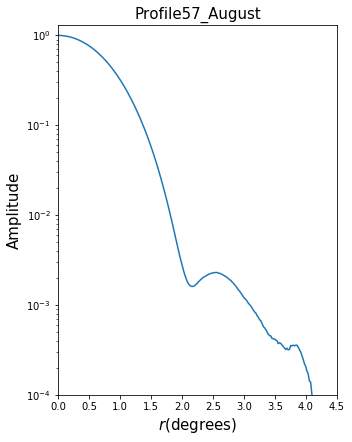

In [135]:
radial_brightness_01 = '/home/bastian/radial_profiles/Det57/radial_brightness_02scan2017-02-13-03-01.txt'
radial_brightness_02 = '/home/bastian/radial_profiles/Det57/radial_brightness_02scan2017-02-13-07-37.txt'
radial_brightness_03 = '/home/bastian/radial_profiles/Det57/radial_brightness_02scan2017-02-14-03-37.txt'#
radial_brightness_04 = '/home/bastian/radial_profiles/Det57/radial_brightness_02scan2017-02-14-08-49.txt'
radial_brightness_05 = '/home/bastian/radial_profiles/Det57/radial_brightness_02scan2017-02-15-04-13.txt'
radial_brightness_06 = '/home/bastian/radial_profiles/Det57/radial_brightness_02scan2017-02-15-09-50.txt'
radial_brightness_07 = '/home/bastian/radial_profiles/Det57/radial_brightness_02scan2017-02-16-04-50.txt'
radial_brightness_08 = '/home/bastian/radial_profiles/Det57/radial_brightness_02scan2017-02-16-10-45.txt'
radial_brightness_09 = '/home/bastian/radial_profiles/Det57/radial_brightness_02scan2017-02-17-05-28.txt'
radial_brightness_10 = '/home/bastian/radial_profiles/Det57/radial_brightness_02scan2017-02-17-11-38.txt'
radial_brightness_11 = '/home/bastian/radial_profiles/Det57/radial_brightness_02scan2017-02-18-05-10.txt'
radial_brightness_12 = '/home/bastian/radial_profiles/Det57/radial_brightness_02scan2017-02-18-07-15.txt'
radial_brightness_13 = '/home/bastian/radial_profiles/Det57/radial_brightness_02scan2017-02-18-11-17.txt'
radial_brightness_14 = '/home/bastian/radial_profiles/Det57/radial_brightness_02scan2017-02-18-13-26.txt'
radial_brightness_15 = '/home/bastian/radial_profiles/Det57/radial_brightness_02scan2017-02-23-12-47.txt'#
radial_brightness_16 = '/home/bastian/radial_profiles/Det57/radial_brightness_02scan2017-02-26-12-37.txt'



radial_brightness_01 = '/home/bastian/radial_profiles/Det57/radial_brightness_08scan2017-08-01-01-34.txt'
radial_brightness_02 = '/home/bastian/radial_profiles/Det57/radial_brightness_08scan2017-08-01-19-58.txt'
radial_brightness_03 = '/home/bastian/radial_profiles/Det57/radial_brightness_08scan2017-08-02-02-23.txt'
radial_brightness_04 = '/home/bastian/radial_profiles/Det57/radial_brightness_08scan2017-08-02-20-41.txt'
radial_brightness_05 = '/home/bastian/radial_profiles/Det57/radial_brightness_08scan2017-08-03-03-12.txt'
radial_brightness_06 = '/home/bastian/radial_profiles/Det57/radial_brightness_08scan2017-08-03-20-28.txt'
radial_brightness_07 = '/home/bastian/radial_profiles/Det57/radial_brightness_08scan2017-08-03-22-34.txt'
radial_brightness_08 = '/home/bastian/radial_profiles/Det57/radial_brightness_08scan2017-08-04-02-54.txt'
radial_brightness_09 = '/home/bastian/radial_profiles/Det57/radial_brightness_08scan2017-08-04-04-58.txt'
radial_brightness_10 = '/home/bastian/radial_profiles/Det57/radial_brightness_08scan2017-08-05-23-05.txt'
radial_brightness_11 = '/home/bastian/radial_profiles/Det57/radial_brightness_08scan2017-08-06-05-37.txt'
radial_brightness_12 = '/home/bastian/radial_profiles/Det57/radial_brightness_08scan2017-08-06-22-57.txt'
radial_brightness_13 = '/home/bastian/radial_profiles/Det57/radial_brightness_08scan2017-08-07-01-02.txt'
radial_brightness_14 = '/home/bastian/radial_profiles/Det57/radial_brightness_08scan2017-08-07-05-16.txt'
radial_brightness_15 = '/home/bastian/radial_profiles/Det57/radial_brightness_08scan2017-08-07-07-21.txt'

#
#scan2017-02-26-12-37

profile_01           = np.loadtxt(radial_brightness_01, dtype=float)
profile_02           = np.loadtxt(radial_brightness_02, dtype=float)
profile_03           = np.loadtxt(radial_brightness_03, dtype=float)
profile_04           = np.loadtxt(radial_brightness_04, dtype=float)
profile_05           = np.loadtxt(radial_brightness_05, dtype=float)
profile_06           = np.loadtxt(radial_brightness_06, dtype=float)
profile_07           = np.loadtxt(radial_brightness_07, dtype=float)
profile_08           = np.loadtxt(radial_brightness_08, dtype=float)
profile_09           = np.loadtxt(radial_brightness_09, dtype=float)
profile_10           = np.loadtxt(radial_brightness_10, dtype=float)
profile_11           = np.loadtxt(radial_brightness_11, dtype=float)
profile_12           = np.loadtxt(radial_brightness_12, dtype=float)
profile_13           = np.loadtxt(radial_brightness_13, dtype=float)
profile_14           = np.loadtxt(radial_brightness_14, dtype=float)
profile_15           = np.loadtxt(radial_brightness_15, dtype=float)

   
r                    = np.loadtxt('/home/bastian/radial_profiles/Det57/radial_coordinate_08scan2017-08-01-01-34.txt', dtype=float)




# Ave_profile


profile       = profile_01 + profile_02 + profile_03 + profile_04  + profile_05 + profile_06 + profile_07 + profile_08 + profile_09 + profile_10 +profile_11 + profile_12 + profile_13 + profile_14+ profile_15 



# profile_16
# profile_15
# profile_04

#profile      =   profile_03     
#profile      =   profile_09 
    
profile  = profile/15


name_profile = '/home/bastian/radial_profiles/Det57/'+'ave_profile_08'+'.txt'
name_radial  = '/home/bastian/radial_profiles/Det57/'+'radius_08'+'.txt'
    
    
np.savetxt(name_profile, profile, fmt='%s') 
np.savetxt(name_radial, r, fmt='%s') 



#################################################################
plt.clf()
figure = plt.figure()
ave_profile = plt.plot(r, profile/profile[1])

plt.title('Profile57_August',fontsize=15)
plt.xlabel('$r$(degrees)',fontsize=15)
plt.ylabel('Amplitude',fontsize=15)
plt.xlim([0,4.5])
plt.yscale('Log')
plt.ylim([10**-4, 1.3])

f = plt.gcf()
f.set_size_inches(5.0,6.8)

plt.show()
#################################################################

plt.clf()
plt.figure()

l3, = plt.plot(theta_r, t,'g', label = 'Fit Moon*beam')
l4, = plt.plot(rad[:297],ave_rings[:297]/ave_rings[1],'--b',label='Moonreconvolution')

plt.xlabel('Angular distance(degrees)')
plt.ylabel('Amplitude')
plt.yscale('Log')
plt.xlim([0,5])
plt.ylim([10**-4, 1.1])
plt.title('Fit Moon/beam convolution - Fit Moon/beam reconvolution')

plt.legend()
f = plt.gcf()
f.set_size_inches(5.0,3.5) 
#plt.savefig("/home/bastian/plots/Moon_beam_convolution_moon_beam_reconvolution.pdf", bbox_inches="tight")
#plt.savefig("/home/bastian/plots/Moon_beam_convolution_moon_beam_reconvolution.png", bbox_inches="tight")
plt.show()




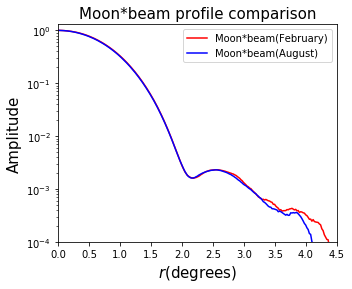

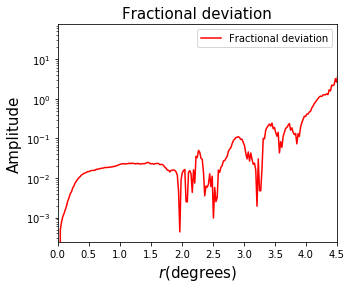

In [5]:

r   = np.loadtxt('/home/bastian/radial_profiles/Det57/radial_coordinate_08scan2017-08-01-01-34.txt', dtype=float)


name_profile_02 = '/home/bastian/radial_profiles/Det57/'+'ave_profile_02'+'.txt'
name_profile_08 = '/home/bastian/radial_profiles/Det57/'+'ave_profile_08'+'.txt'

profile_02  = np.loadtxt(name_profile_02, dtype=float)
profile_08  = np.loadtxt(name_profile_08, dtype=float)


#################################################################
plt.clf()
figure = plt.figure()

ave_profile_02 = plt.plot(r, profile_02/profile_02[1],'r' , label = 'Moon*beam(February)')
ave_profile_08 = plt.plot(r, profile_08/profile_08[1],'b' , label = 'Moon*beam(August)' )

plt.title('Moon*beam profile comparison',fontsize=15)
plt.xlabel('$r$(degrees)',fontsize=15)
plt.ylabel('Amplitude',fontsize=15)
plt.xlim([0,4.5])
plt.yscale('Log')
plt.ylim([10**-4, 1.3])

plt.legend()
f = plt.gcf()
f.set_size_inches(5.0,4.0)

plt.show()


#################################################################


plt.clf()
figure = plt.figure()

ave_profile_02 = plt.plot(r, np.abs(-profile_02/profile_02[1]+profile_08/profile_08[1])/(profile_02/profile_02[1]),'r' ,
                          label = 'Fractional deviation')

plt.title('Fractional deviation',fontsize=15)
plt.xlabel('$r$(degrees)',fontsize=15)
plt.ylabel('Amplitude',fontsize=15)
plt.xlim([0,4.5])
plt.yscale('Log')
#plt.ylim([10**-4, 1.3])

plt.legend()
f = plt.gcf()
f.set_size_inches(5.0,4.0)

plt.show()
#################################################################





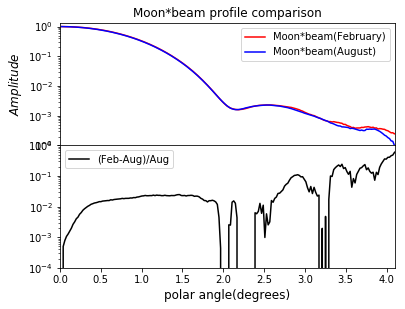

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import numpy.ma as ma
from scipy.optimize import curve_fit
from matplotlib.mlab import griddata
import glob


################################################################  
r   = np.loadtxt('/home/bastian/radial_profiles/Det57/radial_coordinate_08scan2017-08-01-01-34.txt', dtype=float)

name_profile_02 = '/home/bastian/radial_profiles/Det57/'+'ave_profile_02'+'.txt'
name_profile_08 = '/home/bastian/radial_profiles/Det57/'+'ave_profile_08'+'.txt'

profile_02      = np.loadtxt(name_profile_02, dtype=float)
profile_08      = np.loadtxt(name_profile_08, dtype=float)

################################################################     
plt.close('all')        
f, (ax1, ax2) = plt.subplots(2, sharex=True)

ax1.plot(r, profile_02/profile_02[1],'r', label = 'Moon*beam(February)')
ax1.plot(r, profile_08/profile_08[1],'b', label = 'Moon*beam(August)' )

ax1.set_title('Moon*beam profile comparison')
ax1.set_ylabel('$Amplitude$', size= 12) 
#ax1.set_yticks(ticks = [0, 0.25 ,0.5, 0.75,1] ,minor=False)

ax1.set_xlim([0,4.1])
ax1.set_yscale('Log')
ax1.set_ylim([10**-4, 1.3])
ax1.legend()


ax2.plot(r,(-1.0)*((profile_08/profile_08[1]-profile_02/profile_02[1]))/(profile_02/profile_02[1]),'k', label = '(Feb-Aug)/Aug' )


ax2.set_xlabel('polar angle(degrees)', size= 12)
#ax2.set_ylabel('$Amplitude$', size= 12) 

ax2.set_yscale('Log')
ax2.set_ylim([10**-4, 10**0.0])

#ax2.set_xlim([0, l_max - 50])
#ax2.set_ylim([-0.006,0.006])
#ax2.set_xticks(ticks = [0,25,50,75,100,125,150,175,200,225,250] ,minor=False)
#ax2.set_yticks(ticks = [-0.005,-0.0025,0,0.0025 ,0.005] ,minor=False)


ax2.legend()
f.subplots_adjust(hspace=0)
#plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)  

f = plt.gcf()
f.set_size_inches(6.0,4.5)
plt.savefig("/home/bastian/plots/f_error_02_08.png", bbox_inches="tight")       
plt.show()


# Results 'the beam shape '.


In [ ]:
# Deconvolving the signal and then comparing them.




In [ ]:
# 